In [249]:
%matplotlib inline
import matplotlib.pyplot as plt
import ujson as json
import glob as g
import random as rnd
import os.path as op
import time
import math
import numpy as np
from skimage import io, transform
import skimage.color as skc
import re

from tqdm import tqdm

import pandas as pd
import seaborn as sns

import multiprocessing
import hashlib as hl
import scipy.spatial.distance as sd

import subprocess
import editdistance as ed
import itertools as it
import functools as ft

In [305]:
sns.set_context('poster')

In [296]:
def get_text_results(result_dir):
    method = op.basename(result_dir)
    for cat in g.glob(op.join(result_dir,'*')):
        for txt in g.glob(op.join(cat,'*.gt.txt')):
            line_file_name = txt[:-len('.gt.txt')]
            with open(line_file_name + '.gt.txt') as gt_file:
                gt = gt_file.read()
            pred_path = line_file_name + '.txt'
            if op.isfile(pred_path):
                with open(pred_path) as pred_file:
                    pred = pred_file.read()
            else:
                pred = ""
            yield {'catalog': op.basename(cat),
                   'name': op.basename(line_file_name), 
                   'gt': gt.decode('utf8'), 
                   'text': pred.decode('utf8'),
                   'method': method}


In [297]:
result_data = pd.DataFrame(list(it.chain(*[get_text_results(method_dir) for method_dir in g.glob('/media/jakob/bigdata/line_comparision/*')])))
set(result_data['catalog'])

{'S', 'SB', 'SC', 'SD', 'SE'}

In [298]:
result_data['distance'] = result_data.apply(lambda row: ed.eval(row['text'], row['gt']),axis=1)
result_data['total'] = result_data.apply(lambda row:len(row['gt']),axis=1)
result_data['error'] = result_data.apply(lambda row: row['distance'] * 1.0 / row['total'],axis=1)
result_data = result_data.sort_values(['catalog', 'method'])

In [299]:
for key, group in result_data.groupby('catalog'):
    print key,group['total'].sum(), group['distance'].sum()* 1.0/  group['total'].sum(), group['distance'].mean()

S 5619 0.379426944296 8.99578059072
SB 2421 0.19083023544 5.13333333333
SC 3033 0.129904385097 6.91228070175
SD 1299 0.160123171671 6.93333333333
SE 420 0.185714285714 5.2


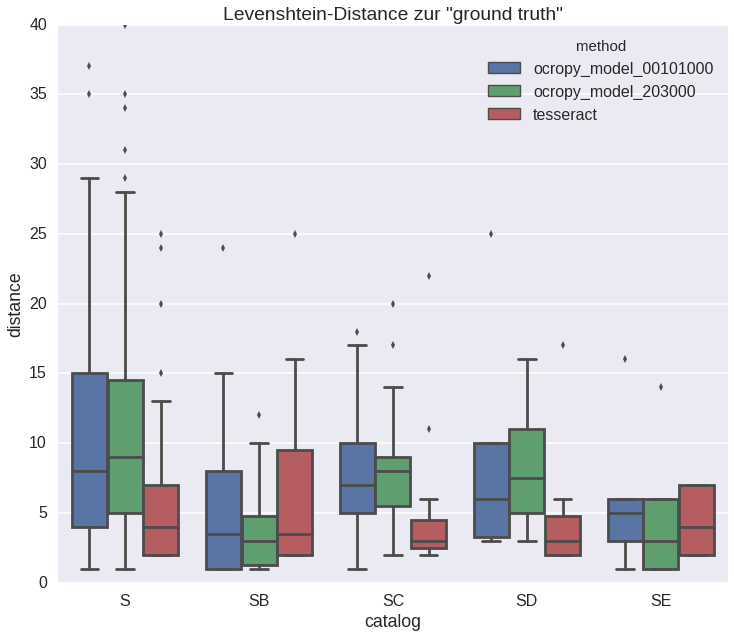

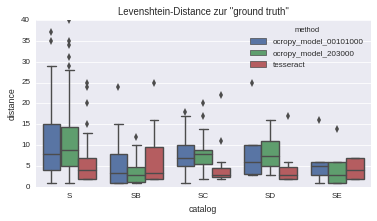

In [329]:
sns.set_context('poster')
fig = plt.figure(figsize=(12,10), dpi=300)
ax = sns.boxplot(x='catalog', y='distance', data=result_data, hue='method')
ax.set_title('Levenshtein-Distance zur "ground truth"')
plt.savefig('../plots/gt_distance_poster.jpg', dpi=300)
plt.show()

sns.set_context('paper')
fig = plt.figure(figsize=(6,3), dpi=600)
ax = sns.boxplot(x='catalog', y='distance', data=result_data, hue='method')
ax.set_title('Levenshtein-Distance zur "ground truth"')
plt.savefig('../plots/gt_distance_paper.jpg', dpi=300)
plt.show()